In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import opensmile
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score 
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
voice_train = pd.read_pickle("./audio_tables/voice_train_split_df")
voice_test = pd.read_pickle("./audio_tables/voice_test_split_df")
voice_test_mismatch = pd.read_pickle("./combined_voice_votes_incorrect")

In [6]:
def extract_opensmile_features(voice_data, feature_set):
    smile = opensmile.Smile(
        feature_set=feature_set,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    return smile.process_files(['./CREMA-D/AudioWAV/'+name+'.wav' for name in list(voice_data.fileName)])

def preprocess_audio_df(voice_data, labelencoder, scaler, feature_set):
    voice_data_os = extract_opensmile_features(voice_data, feature_set)
    
    voice_data_os.index = [i[0].split("/")[-1] for i in voice_data_os.index]
    voice_data_os["intendedEmo"] = list(voice_data.intendedEmo)
    
    voice_data_os["intendedEmo"] = labelencoder.fit_transform(voice_data_os["intendedEmo"])
    
    
    normalised_voice_data_os = voice_data_os.drop(columns=["intendedEmo"])
    normalised_voice_data_os.values[:] = scaler.fit_transform(voice_data_os.drop(columns=["intendedEmo"]))
    normalised_voice_data_os["intendedEmo"] = voice_data_os["intendedEmo"]
    return normalised_voice_data_os

In [ ]:
labelencoder = pd.read_pickle("label_encoder.pkl")
standard_scaler = StandardScaler()
standardised_voice_train_os = preprocess_audio_df(voice_train, labelencoder, standard_scaler, opensmile.FeatureSet.ComParE_2016)

In [7]:
pd.to_pickle(standardised_voice_train_os, "./audio_tables/voice_train_os_clean_stand_df")

In [3]:
standardised_voice_train_os = pd.read_pickle("./audio_tables/voice_train_os_clean_stand_df")

In [18]:
stand_correlation = standardised_voice_train_os.corrwith(standardised_voice_train_os["intendedEmo"], method='pearson')
stand_correlation

audspec_lengthL1norm_sma_range       -0.672000
audspec_lengthL1norm_sma_maxPos      -0.207850
audspec_lengthL1norm_sma_minPos       0.047559
audspec_lengthL1norm_sma_quartile1   -0.252096
audspec_lengthL1norm_sma_quartile2   -0.558719
                                        ...   
mfcc_sma_de[14]_meanRisingSlope      -0.248899
mfcc_sma_de[14]_stddevRisingSlope    -0.184677
mfcc_sma_de[14]_meanFallingSlope     -0.248486
mfcc_sma_de[14]_stddevFallingSlope   -0.179668
intendedEmo                           1.000000
Length: 6374, dtype: float64

In [20]:
len(stand_correlation[np.abs(stand_correlation)>0.3])/len(stand_correlation)

0.2867900847191716

In [23]:
y_train = standardised_voice_train_os.intendedEmo
X_train = standardised_voice_train_os.drop(columns=["intendedEmo"])

In [24]:
# voice_train_X, voice_train_y = smote_oversample(X_train, y_train)
voice_train_X, voice_train_y = X_train, y_train

In [17]:
voice_train_y.value_counts()

4    832
0    616
2    326
1    274
3    264
5    167
Name: intendedEmo, dtype: int64

In [ ]:
# defining parameter range
param_grid = {'classifier__C': [10, 100, 1000], 
              'classifier__gamma': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
# fitting the model for grid search
grid.fit(voice_train_X, voice_train_y)


# train score was 100% w/ C=100

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.792, test=0.738) total time= 1.7min
[CV 2/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.798, test=0.665) total time= 1.7min
[CV 3/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.780, test=0.750) total time= 1.7min
[CV 4/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.794, test=0.661) total time= 1.7min
[CV 5/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.785, test=0.738) total time= 1.7min
[CV 6/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.775, test=0.758) total time= 1.7min
[CV 7/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.787, test=0.694) total time= 1.7min
[CV 8/

In [17]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=10, gamma=0.0001, random_state=4)]])

 The best score across ALL searched params:
 0.790642549301293

 The best parameters across ALL searched params:
 {'classifier__C': 10, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}


In [ ]:
pd.to_pickle(grid, "./grid_compare_clean_stand_trainscores")

#### Plot GridSearchCV results using https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv

In [14]:
grid = pd.read_pickle("./grid_compare_clean_stand_trainscores")

In [58]:
df = pd.DataFrame(grid.cv_results_)
df.loc[df["param_classifier__gamma"]==0.00001][["mean_train_score", "mean_test_score", "param_classifier__C", "param_classifier__gamma"]]

,mean_train_score,mean_test_score,param_classifier__C,param_classifier__gamma
1,0.977679,0.789834,10,0.00001
8,1.000000,0.788626,100,0.00001
15,1.000000,0.788626,1000,0.00001


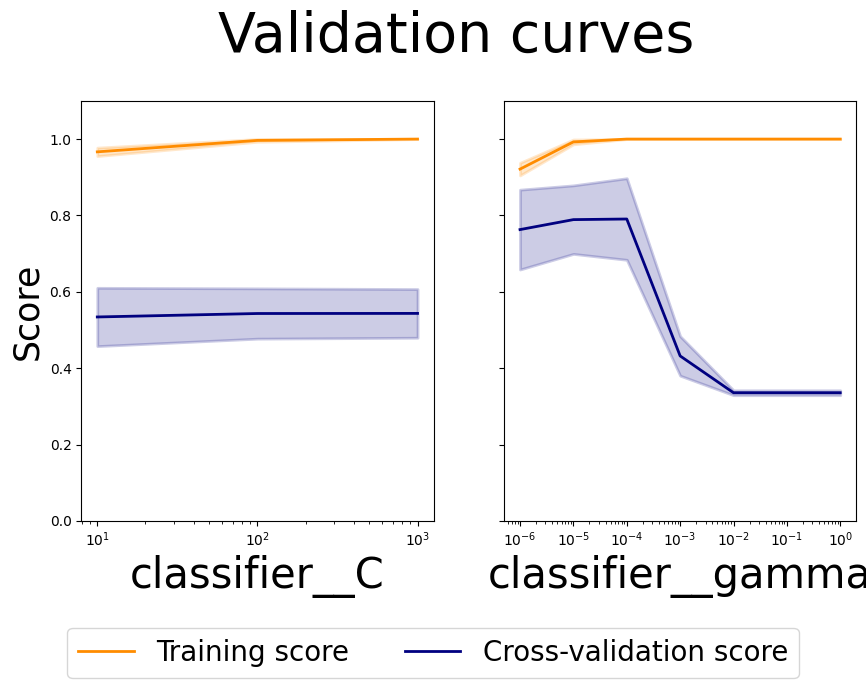

In [34]:
grid_params = {'classifier__C': [10, 100, 1000], 
              'classifier__gamma': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
              } 


df = pd.DataFrame(grid.cv_results_)
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

# Following is from https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv
# https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
def pooled_var(stds):
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


fig, axes = plt.subplots(1, len(grid_params), 
                         figsize = (5*len(grid_params), 7),
                         sharey='row')
axes[0].set_ylabel("Score", fontsize=25)
lw = 2

for idx, (param_name, param_range) in enumerate(grid_params.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=30)
    axes[idx].set_ylim(0.0, 1.1)
    axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                color="darkorange", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                    color="darkorange", lw=lw)
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                color="navy", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                    color="navy", lw=lw)
    axes[idx].set_xscale('log')

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=40)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

fig.subplots_adjust(bottom=0.25, top=0.85)  
plt.show()

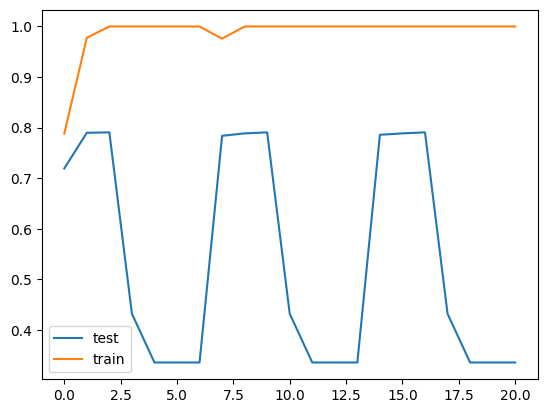

In [35]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

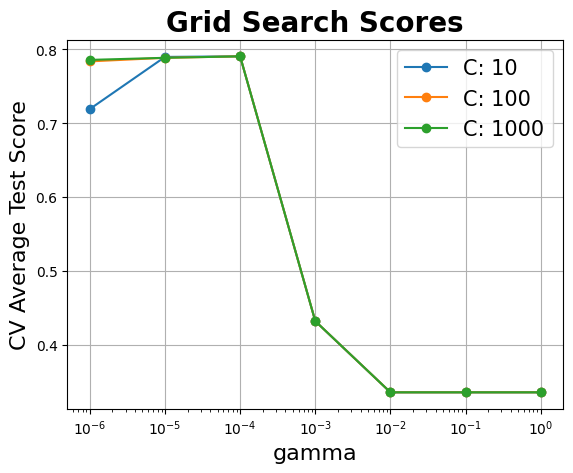

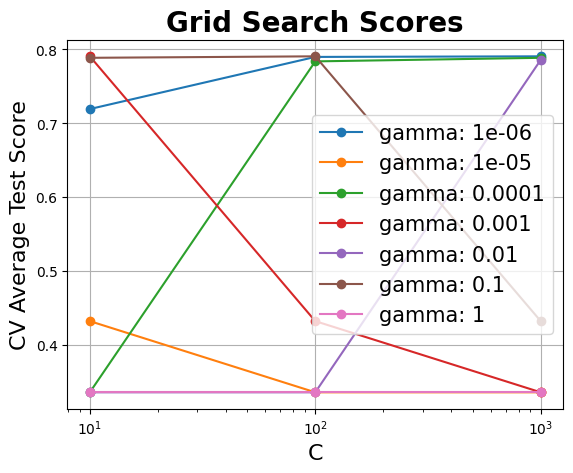

In [36]:
Cs = grid_params["classifier__C"]
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Function copied and adapted from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

#     scores_sd = cv_results['std_test_score']
#     scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Test Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    ax.set_xscale('log')

# Calling Method 
plot_grid_search(grid.cv_results_,  grid_params["classifier__gamma"],grid_params["classifier__C"], 'gamma', 'C')
plot_grid_search(grid.cv_results_,  grid_params["classifier__C"], grid_params["classifier__gamma"], 'C', 'gamma')

In [20]:
standardised_voice_test_os = pd.read_pickle("./audio_tables/voice_test_os_clean_stand_df")
y_test_match = standardised_voice_test_os.intendedEmo
X_test_match = standardised_voice_test_os.drop(columns=["intendedEmo"])

In [26]:
%%time
best_svm_clean = SVC(C=10, gamma=0.0001, random_state=4, kernel="rbf").fit(voice_train_X, voice_train_y)

CPU times: user 34.4 s, sys: 128 ms, total: 34.5 s
Wall time: 34.5 s


In [27]:
%%time
y_pred_match = best_svm_clean.predict(X_test_match)

CPU times: user 11.4 s, sys: 16 ms, total: 11.5 s
Wall time: 11.4 s


In [28]:
accuracy = accuracy_score(y_test_match,y_pred_match)*100
confusion_mat = confusion_matrix(y_test_match,y_pred_match)

# Printing the results
print("Accuracy for SVM is:",accuracy)
print("Confusion Matrix")
print(confusion_mat)
# 80.3225806451613

Accuracy for SVM is: 80.3225806451613
Confusion Matrix
[[137   6   5   5   1   0]
 [  4  46   5   2  11   1]
 [  7   5  56   5   4   4]
 [ 13   3   4  41   5   0]
 [  1   5   1   5 195   1]
 [  1   5   3   0  10  23]]


## Test on mismatched and ambiguous

In [29]:
standardised_voice_test_mismatch = pd.read_pickle("./audio_tables/voice_test_mismatch_clean_stand_df")

In [30]:
y_test_mismatch = standardised_voice_test_mismatch.intendedEmo
X_test_mismatch = standardised_voice_test_mismatch.drop(columns=["intendedEmo"])

In [31]:
%%time
y_pred_mismatch = best_svm_clean.predict(X_test_mismatch)

CPU times: user 1min 19s, sys: 215 ms, total: 1min 20s
Wall time: 1min 20s


In [32]:
mismatch_accuracy = accuracy_score(y_test_mismatch,y_pred_mismatch)*100
mismatch_confusion_mat = confusion_matrix(y_test_mismatch,y_pred_mismatch)

# Printing the results
print("Accuracy for SVM on mismatched and ambiguous data is:",mismatch_accuracy) # 33.43311075293576
print("Confusion Matrix")
print(mismatch_confusion_mat)

Accuracy for SVM on mismatched and ambiguous data is: 33.43311075293576
Confusion Matrix
[[423  23  11  17  27   0]
 [249 310  47  35 248  39]
 [162  62 239  39 277  85]
 [396  43  79 272 149   2]
 [ 11   0   3   0  33   0]
 [ 41  92 128  11 615 175]]


In [13]:
labelencoder = pd.read_pickle("label_encoder.pkl")

mismatch_trues = labelencoder.inverse_transform(y_test_mismatch)
mismatch_preds = labelencoder.inverse_transform(y_pred_mismatch)

match_trues = labelencoder.inverse_transform(y_test_match)
match_preds = labelencoder.inverse_transform(y_pred_match)

In [15]:
match_test_res = pd.DataFrame({
    "preds": match_preds,
    "trues": match_trues
})
pd.to_pickle(match_test_res, "./test_results/audio_matching_results_df")
# 80.3225806451613

In [16]:
mismatch_test_res = pd.DataFrame({
    "preds": mismatch_preds,
    "trues": mismatch_trues
})
pd.to_pickle(mismatch_test_res, "./test_results/audio_mismatching_results_df")
# 33.43311075293576

/tmp/ipykernel_317829/1812099125.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_voice_cm / all_voice_cm.astype(np.float).sum(axis=1)


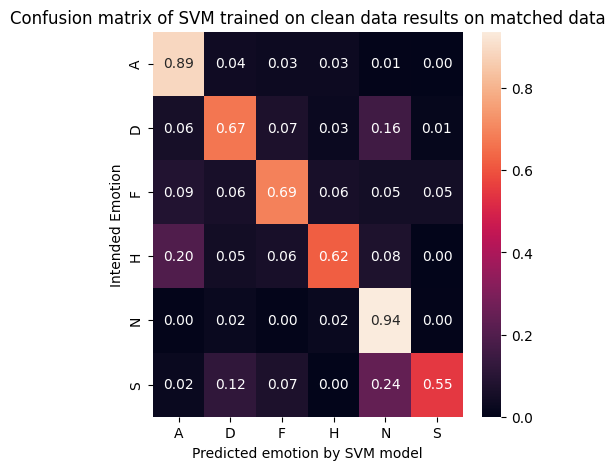

/tmp/ipykernel_317829/1812099125.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_voice_cm / all_voice_cm.astype(np.float).sum(axis=1)


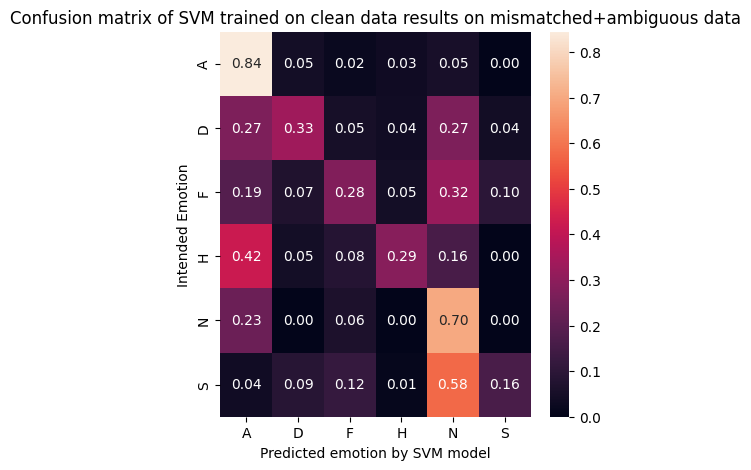

In [47]:
import seaborn as sns

def plot_cm(trues, preds, targets, title):
    # adapted from https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix


    all_voice_cm = confusion_matrix(trues, preds, labels=targets, normalize='true')

    all_voice_cm / all_voice_cm.astype(np.float).sum(axis=1)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(all_voice_cm, annot=True, fmt='.2f', xticklabels=targets, yticklabels=targets)
    plt.ylabel('Intended Emotion')
    plt.xlabel('Predicted emotion by SVM model')
    plt.title(title)
    plt.show(block=False)

TARGET_NAMES = ["A", "D", "F", "H", "N", "S"]

mismatch_trues = labelencoder.inverse_transform(y_test_mismatch)
mismatch_preds = labelencoder.inverse_transform(y_pred_mismatch)

match_trues = labelencoder.inverse_transform(y_test_match)
match_preds = labelencoder.inverse_transform(y_pred_match)

plot_cm(match_trues, match_preds, TARGET_NAMES, "Confusion matrix of SVM trained on clean data results on matched data")

plot_cm(mismatch_trues, mismatch_preds, TARGET_NAMES, "Confusion matrix of SVM trained on clean data results on mismatched+ambiguous data")

### Experiment w/ next best SVM: train:0.977679; val:0.789834; C:10; gamma:0.00001

In [59]:
next_best_svm_clean = SVC(C=10, gamma=0.00001, random_state=4, kernel="rbf").fit(voice_train_X, voice_train_y)

In [60]:
y_pred_match = next_best_svm_clean.predict(X_test_match)

accuracy = accuracy_score(y_test_match,y_pred_match)*100
confusion_mat = confusion_matrix(y_test_match,y_pred_match)

# Printing the results
print("Accuracy for SVM is:",accuracy)
print("Confusion Matrix")
print(confusion_mat)

Accuracy for SVM is: 80.16129032258064
Confusion Matrix
[[136   6   5   5   2   0]
 [  4  46   3   2  13   1]
 [  6   4  55   5   8   3]
 [ 12   4   3  41   6   0]
 [  2   2   3   2 198   1]
 [  1   4   2   0  14  21]]


In [61]:
y_test_mismatch = standardised_voice_test_mismatch.intendedEmo
X_test_mismatch = standardised_voice_test_mismatch.drop(columns=["intendedEmo"])

y_pred_mismatch = next_best_svm_clean.predict(X_test_mismatch)

mismatch_accuracy = accuracy_score(y_test_mismatch,y_pred_mismatch)*100
mismatch_confusion_mat = confusion_matrix(y_test_mismatch,y_pred_mismatch)

# Printing the results
print("Accuracy for SVM on mismatched and ambiguous data is:",mismatch_accuracy)
print("Confusion Matrix")
print(mismatch_confusion_mat)

Accuracy for SVM on mismatched and ambiguous data is: 31.36081049965462
Confusion Matrix
[[420  21  10  20  30   0]
 [246 273  51  32 290  36]
 [166  50 222  38 315  73]
 [407  36  78 252 166   2]
 [ 10   0   4   0  33   0]
 [ 37  81 107  10 665 162]]


## Experimenting with smaller C values

In [ ]:
# defining parameter range
lower_param_grid = {'classifier__C': [1, 0.1, 0.01, 0.001, 0.0001], 
              'classifier__gamma': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
lower_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=lower_param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
# fitting the model for grid search
lower_grid.fit(voice_train_X, voice_train_y)


# train score was 100% w/ C=100

Fitting 10 folds for each of 35 candidates, totalling 350 fits
[CV 1/10] END classifier__C=1, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.563, test=0.601) total time= 2.5min
[CV 2/10] END classifier__C=1, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.575, test=0.504) total time= 2.5min
[CV 3/10] END classifier__C=1, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.569, test=0.565) total time= 2.5min
[CV 4/10] END classifier__C=1, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.576, test=0.516) total time= 2.5min
[CV 5/10] END classifier__C=1, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.570, test=0.556) total time= 2.5min
[CV 6/10] END classifier__C=1, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.556, test=0.573) total time= 2.5min
[CV 7/10] END classifier__C=1, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.565, test=0.520) total time= 2.5min
[CV 8/10] END

In [4]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",lower_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",lower_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",lower_grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=1, gamma=0.0001, random_state=4)]])

 The best score across ALL searched params:
 0.7745020895912238

 The best parameters across ALL searched params:
 {'classifier__C': 1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}


In [ ]:
pd.to_pickle(lower_grid, "./grid_lowvals_compare_clean_stand_trainscores")

In [3]:
lower_grid = pd.read_pickle("./grid_lowvals_compare_clean_stand_trainscores")

## Experimenting with Linear kernel

In [7]:
# defining parameter range
param_grid_linear = {'classifier__C': [0.1, 1, 10, 100, 1000], 
              'classifier__gamma': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
              'classifier__kernel': ['linear']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_linear = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_linear,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
# fitting the model for grid search
grid_linear.fit(voice_train_X, voice_train_y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits
[CV 1/10] END classifier__C=0.1, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=1.000, test=0.806) total time=  44.9s
[CV 2/10] END classifier__C=0.1, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=1.000, test=0.766) total time=  43.1s
[CV 3/10] END classifier__C=0.1, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=1.000, test=0.798) total time=  44.6s
[CV 4/10] END classifier__C=0.1, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=1.000, test=0.742) total time=  44.1s
[CV 5/10] END classifier__C=0.1, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=1.000, test=0.802) total time=  44.9s
[CV 6/10] END classifier__C=0.1, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=1.000, test=0.798) total time=  43.8s
[CV 7/10] END classifier__C=0.1, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=1.000, test=0.79

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 1000],
                         'classifier__gamma': [1e-06, 1e-05, 0.0001, 0.001,
                                               0.01, 0.1, 1],
                         'classifier__kernel': ['linear']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [9]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_linear.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_linear.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_linear.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier',
                 SVC(C=0.1, gamma=1e-06, kernel='linear', random_state=4)]])

 The best score across ALL searched params:
 0.786207065430325

 The best parameters across ALL searched params:
 {'classifier__C': 0.1, 'classifier__gamma': 1e-06, 'classifier__kernel': 'linear'}


In [8]:
pd.to_pickle(grid_linear, "./grid_lin_compare_clean_stand_trainscores")

In [7]:
# defining parameter range
param_grid_linear = {'classifier__C': [0.0001,0.001, 0.01, 0.1], 
              'classifier__gamma': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
              'classifier__kernel': ['linear']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_linear2 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_linear,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
# fitting the model for grid search
grid_linear2.fit(voice_train_X, voice_train_y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
[CV 1/10] END classifier__C=0.0001, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=0.933, test=0.790) total time= 1.1min
[CV 2/10] END classifier__C=0.0001, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=0.934, test=0.742) total time= 1.1min
[CV 3/10] END classifier__C=0.0001, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=0.933, test=0.794) total time= 1.1min
[CV 4/10] END classifier__C=0.0001, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=0.936, test=0.758) total time= 1.1min
[CV 5/10] END classifier__C=0.0001, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=0.936, test=0.774) total time= 1.1min
[CV 6/10] END classifier__C=0.0001, classifier__gamma=1e-06, classifier__kernel=linear;, score=(train=0.933, test=0.823) total time= 1.1min
[CV 7/10] END classifier__C=0.0001, classifier__gamma=1e-06, classifier__kernel=linear;, score=(t

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [0.0001, 0.001, 0.01, 0.1],
                         'classifier__gamma': [1e-06, 1e-05, 0.0001, 0.001,
                                               0.01, 0.1, 1],
                         'classifier__kernel': ['linear']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [8]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_linear2.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_linear2.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_linear2.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier',
                 SVC(C=0.01, gamma=1e-06, kernel='linear', random_state=4)]])

 The best score across ALL searched params:
 0.786207065430325

 The best parameters across ALL searched params:
 {'classifier__C': 0.01, 'classifier__gamma': 1e-06, 'classifier__kernel': 'linear'}


In [9]:
if grid_linear2.best_score_> 0.790642549301293:
    pd.to_pickle(grid_linear, "./grid_lin2_compare_clean_stand_trainscores")

## Experimenting with eGEMAPS

In [7]:
labelencoder = pd.read_pickle("label_encoder.pkl")
standard_scaler = StandardScaler()
stand_voice_train_emps = preprocess_audio_df(
    voice_train,
    labelencoder,
    standard_scaler,
    opensmile.FeatureSet.eGeMAPSv02
)
y_train_emps = stand_voice_train_emps.intendedEmo
X_train_emps = stand_voice_train_emps.drop(columns=["intendedEmo"])
voice_train_X_emps, voice_train_y_emps = X_train_emps, y_train_emps
voice_train_X_emps

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
1008_IEO_DIS_HI.wav,1.216057,-0.852179,1.294719,1.236674,0.930704,-0.666063,-0.121397,-0.069122,-0.435577,-0.273453,...,-1.013613,0.666070,-0.046580,-0.731473,-1.107841,0.419387,1.020444,0.939813,1.603593,0.291882
1049_ITS_FEA_XX.wav,0.581159,-1.017552,0.712804,0.572740,0.353420,-0.692181,0.278119,0.370908,-0.302035,-0.352720,...,-0.563045,-0.034829,-0.637957,1.763072,0.915172,-0.406484,-0.041147,-0.763093,-1.064554,-1.055971
1028_IEO_DIS_MD.wav,0.188418,-0.206824,0.211466,0.105040,0.039251,-0.339649,0.469479,0.502809,0.135150,0.163641,...,-1.328554,-0.383253,-0.324730,0.343866,0.408914,-0.386703,-0.382871,-0.203314,0.069580,-0.360885
1091_WSI_ANG_XX.wav,-0.587936,3.748061,-2.608287,-0.086063,-0.052101,5.073853,0.702170,0.509627,0.040315,-0.087318,...,-0.724301,0.730165,-0.511303,0.751992,3.171268,-0.814699,-0.646169,-1.195203,-1.125904,-0.374890
1029_MTI_ANG_XX.wav,1.232325,-0.304114,0.949700,1.359230,1.271643,0.717228,-0.023652,0.018494,-0.281909,-0.196180,...,1.586144,-1.708803,2.256766,-0.439144,-0.959248,1.977168,1.346015,-0.120821,-0.206686,1.795534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014_WSI_ANG_XX.wav,0.433478,-0.195080,0.574284,0.432853,0.225847,-0.678243,-0.337819,-0.383808,-0.093903,-0.404267,...,0.231428,-0.013688,0.615600,0.156378,0.527666,-0.318881,-0.738978,-0.329580,0.263316,1.188968
1011_WSI_NEU_XX.wav,-1.353763,0.700374,-1.219089,-1.396547,-1.549453,-0.750946,2.571594,-0.536836,-0.241665,-0.189284,...,-1.301558,0.154685,-0.644001,-0.187749,0.172660,-0.742767,-0.781800,-0.077049,0.141276,-1.067494
1025_WSI_ANG_XX.wav,1.148606,0.288641,0.740611,0.995616,1.303567,1.197873,-0.145088,-0.463052,-0.083191,-0.198330,...,0.173953,0.417461,0.478816,1.882572,1.905189,-0.686249,-0.812027,-0.843062,-0.661462,0.139360
1064_TSI_DIS_XX.wav,-0.452214,0.405895,-0.854592,-0.044688,-0.343096,0.994932,-0.068968,-0.536836,-0.551882,-0.404267,...,-0.106133,0.316266,-0.589283,-1.627238,-1.556240,-0.577922,-0.640129,2.536656,0.436129,-0.778329


In [6]:
# defining parameter range
param_grid = {'classifier__C': [10, 100, 1000], 
              'classifier__gamma': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_emps = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
# fitting the model for grid search
grid_emps.fit(voice_train_X_emps, voice_train_y_emps)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.491, test=0.544) total time=   3.1s
[CV 2/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.450, test=0.423) total time=   2.8s
[CV 3/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.461, test=0.496) total time=   2.8s
[CV 4/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.471, test=0.399) total time=   2.7s
[CV 5/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.468, test=0.464) total time=   2.8s
[CV 6/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.452, test=0.460) total time=   2.7s
[CV 7/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.470, test=0.468) total time=   2.7s
[CV 8/

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [10, 100, 1000],
                         'classifier__gamma': [1e-06, 1e-05, 0.0001, 0.001,
                                               0.01, 0.1, 1],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [7]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_emps.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_emps.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_emps.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=100, gamma=0.001, random_state=4)]])

 The best score across ALL searched params:
 0.6825306908710983

 The best parameters across ALL searched params:
 {'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}


In [8]:
pd.to_pickle(grid_emps, "./grid_egemapsv02_clean_stand_trainscores")

### Testing eGEMAPS SVM

In [13]:
standardised_voice_test_match_egemps = preprocess_audio_df(
    voice_test,
    labelencoder,
    standard_scaler,
    opensmile.FeatureSet.eGeMAPSv02
)

y_test_match_egmps = standardised_voice_test_match_egemps.intendedEmo
X_test_match_egmps = standardised_voice_test_match_egemps.drop(columns=["intendedEmo"])

In [14]:
grid_emps = pd.read_pickle("./grid_egemapsv02_clean_stand_trainscores")
best_svm_egemps = SVC(C=100, gamma=0.001, random_state=4, kernel="rbf").fit(voice_train_X_emps, voice_train_y_emps)
standardised_voice_test_match_egemps 

y_pred_match_egemps = best_svm_egemps.predict(X_test_match_egmps)

accuracy_egemps = accuracy_score(y_test_match_egmps,y_pred_match_egemps)*100
confusion_mat_egemps = confusion_matrix(y_test_match_egmps,y_pred_match_egemps)

# Printing the results
print("Accuracy for SVM is:",accuracy_egemps)
print("Confusion Matrix")
print(confusion_mat_egemps)

Accuracy for SVM is: 70.3225806451613
Confusion Matrix
[[135   6   4   5   4   0]
 [  6  24   5   3  28   3]
 [  7   6  45   6  12   5]
 [ 14   5   8  31   8   0]
 [  5   9   4   2 186   2]
 [  1   2   7   1  16  15]]


In [15]:
standardised_voice_test_mismatch_egemps = preprocess_audio_df(
    voice_test_mismatch,
    labelencoder,
    standard_scaler,
    opensmile.FeatureSet.eGeMAPSv02
)

y_test_mismatch_egmps = standardised_voice_test_mismatch_egemps.intendedEmo
X_test_mismatch_egmps = standardised_voice_test_mismatch_egemps.drop(columns=["intendedEmo"])

y_pred_mismatch_egemps = best_svm_egemps.predict(X_test_mismatch_egmps)

accuracy_mismatch_egemps = accuracy_score(y_test_mismatch_egmps,y_pred_mismatch_egemps)*100
confusion_mat_mismatch_egemps = confusion_matrix(y_test_mismatch_egmps,y_pred_mismatch_egemps)

# Printing the results
print("Accuracy for SVM is:",accuracy_mismatch_egemps)
print("Confusion Matrix")
print(confusion_mat_mismatch_egemps)

Accuracy for SVM is: 28.966152429196406
Confusion Matrix
[[398  34  16  25  26   2]
 [234 245  85  39 295  30]
 [164  61 276  58 249  56]
 [456  65 130 181 104   5]
 [ 11   4   4   0  27   1]
 [ 52 102 145  13 619 131]]


## Experimenting with GEMAPS

In [17]:
labelencoder = pd.read_pickle("label_encoder.pkl")
standard_scaler = StandardScaler()
stand_voice_train_mps = preprocess_audio_df(
    voice_train,
    labelencoder,
    standard_scaler,
    opensmile.FeatureSet.GeMAPSv01b
)
y_train_mps = stand_voice_train_mps.intendedEmo
X_train_mps = stand_voice_train_mps.drop(columns=["intendedEmo"])
voice_train_X_mps, voice_train_y_mps = X_train_mps, y_train_mps
voice_train_X_mps

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
1008_IEO_DIS_HI.wav,1.216057,-0.852179,1.294719,1.236674,0.930704,-0.666063,-0.121397,-0.069122,-0.435577,-0.273453,...,0.448369,-0.459403,-1.013613,0.666070,-0.731473,-1.107841,0.419387,1.020444,0.939813,1.603593
1049_ITS_FEA_XX.wav,0.581159,-1.017552,0.712804,0.572740,0.353420,-0.692181,0.278119,0.370908,-0.302035,-0.352720,...,-0.551659,0.655968,-0.563045,-0.034829,1.763072,0.915172,-0.406484,-0.041147,-0.763093,-1.064554
1028_IEO_DIS_MD.wav,0.188418,-0.206824,0.211466,0.105040,0.039251,-0.339649,0.469479,0.502809,0.135150,0.163641,...,-0.015080,0.172312,-1.328554,-0.383253,0.343866,0.408914,-0.386703,-0.382871,-0.203314,0.069580
1091_WSI_ANG_XX.wav,-0.587936,3.748061,-2.608287,-0.086063,-0.052101,5.073853,0.702170,0.509627,0.040315,-0.087318,...,0.496554,-0.582636,-0.724301,0.730165,0.751992,3.171268,-0.814699,-0.646169,-1.195203,-1.125904
1029_MTI_ANG_XX.wav,1.232325,-0.304114,0.949700,1.359230,1.271643,0.717228,-0.023652,0.018494,-0.281909,-0.196180,...,-0.160270,-0.364466,1.586144,-1.708803,-0.439144,-0.959248,1.977168,1.346015,-0.120821,-0.206686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014_WSI_ANG_XX.wav,0.433478,-0.195080,0.574284,0.432853,0.225847,-0.678243,-0.337819,-0.383808,-0.093903,-0.404267,...,1.596430,-1.897034,0.231428,-0.013688,0.156378,0.527666,-0.318881,-0.738978,-0.329580,0.263316
1011_WSI_NEU_XX.wav,-1.353763,0.700374,-1.219089,-1.396547,-1.549453,-0.750946,2.571594,-0.536836,-0.241665,-0.189284,...,-0.796351,0.613426,-1.301558,0.154685,-0.187749,0.172660,-0.742767,-0.781800,-0.077049,0.141276
1025_WSI_ANG_XX.wav,1.148606,0.288641,0.740611,0.995616,1.303567,1.197873,-0.145088,-0.463052,-0.083191,-0.198330,...,0.903344,-0.920520,0.173953,0.417461,1.882572,1.905189,-0.686249,-0.812027,-0.843062,-0.661462
1064_TSI_DIS_XX.wav,-0.452214,0.405895,-0.854592,-0.044688,-0.343096,0.994932,-0.068968,-0.536836,-0.551882,-0.404267,...,0.905765,-1.241368,-0.106133,0.316266,-1.627238,-1.556240,-0.577922,-0.640129,2.536656,0.436129


In [10]:
# defining parameter range
param_grid = {'classifier__C': [10, 100, 1000], 
              'classifier__gamma': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
              'classifier__kernel': ['rbf']} 


# SMOTE applied as pipline as mentioned in https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=4)],
                                ['classifier', SVC(random_state=4)]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                   shuffle=True,
                                   random_state=4,
                                  )
grid_mps = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    refit=True,
    verbose=3,
    return_train_score=True
)
  
# fitting the model for grid search
grid_mps.fit(voice_train_X_mps, voice_train_y_mps)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.494, test=0.520) total time=   2.6s
[CV 2/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.463, test=0.444) total time=   2.6s
[CV 3/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.462, test=0.468) total time=   2.6s
[CV 4/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.469, test=0.399) total time=   2.6s
[CV 5/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.471, test=0.468) total time=   2.6s
[CV 6/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.459, test=0.456) total time=   2.6s
[CV 7/10] END classifier__C=10, classifier__gamma=1e-06, classifier__kernel=rbf;, score=(train=0.463, test=0.476) total time=   2.7s
[CV 8/

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=4)],
                                       ['classifier', SVC(random_state=4)]]),
             param_grid={'classifier__C': [10, 100, 1000],
                         'classifier__gamma': [1e-06, 1e-05, 0.0001, 0.001,
                                               0.01, 0.1, 1],
                         'classifier__kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [11]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_mps.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_mps.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_mps.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('smote', SMOTE(random_state=4)),
                ['classifier', SVC(C=10, gamma=0.01, random_state=4)]])

 The best score across ALL searched params:
 0.6692144442993341

 The best parameters across ALL searched params:
 {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}


In [12]:
pd.to_pickle(grid_mps, "./grid_gemapsv01b_clean_stand_trainscores")

### Testing GEMAPS with SVM

In [18]:
standardised_voice_test_match_gemps = preprocess_audio_df(
    voice_test,
    labelencoder,
    standard_scaler,
    opensmile.FeatureSet.GeMAPSv01b
)

y_test_match_gmps = standardised_voice_test_match_gemps.intendedEmo
X_test_match_gmps = standardised_voice_test_match_gemps.drop(columns=["intendedEmo"])

grid_mps = pd.read_pickle("./grid_gemapsv01b_clean_stand_trainscores")
best_svm_gemps = SVC(C=10, gamma=0.01, random_state=4, kernel="rbf").fit(voice_train_X_mps, voice_train_y_mps)

y_pred_match_gemps = best_svm_gemps.predict(X_test_match_gmps)

accuracy_gemps = accuracy_score(y_test_match_gmps,y_pred_match_gemps)*100
confusion_mat_gemps = confusion_matrix(y_test_match_gmps,y_pred_match_gemps)

# Printing the results
print("Accuracy for SVM is:",accuracy_gemps)
print("Confusion Matrix")
print(confusion_mat_gemps)

Accuracy for SVM is: 68.87096774193549
Confusion Matrix
[[131   5   4   8   6   0]
 [  4  16   5   7  34   3]
 [  9   7  43   7  11   4]
 [ 13   3   9  33   8   0]
 [  7   5   5   2 186   3]
 [  0   4   3   0  17  18]]


In [19]:
standardised_voice_test_mismatch_gemps = preprocess_audio_df(
    voice_test_mismatch,
    labelencoder,
    standard_scaler,
    opensmile.FeatureSet.GeMAPSv01b
)

y_test_mismatch_gmps = standardised_voice_test_mismatch_gemps.intendedEmo
X_test_mismatch_gmps = standardised_voice_test_mismatch_gemps.drop(columns=["intendedEmo"])

y_pred_mismatch_gemps = best_svm_gemps.predict(X_test_mismatch_gmps)

accuracy_mismatch_gemps = accuracy_score(y_test_mismatch_gmps,y_pred_mismatch_gemps)*100
confusion_mat_mismatch_gemps = confusion_matrix(y_test_mismatch_gmps,y_pred_mismatch_gemps)

# Printing the results
print("Accuracy for SVM is:",accuracy_mismatch_gemps)
print("Confusion Matrix")
print(confusion_mat_mismatch_gemps)

Accuracy for SVM is: 27.49251669352982
Confusion Matrix
[[405  25  12  24  35   0]
 [254 202  66  50 331  25]
 [174  61 254  45 279  51]
 [454  46 122 179 132   8]
 [ 11   2   6   0  27   1]
 [ 54  91 107  15 668 127]]
